In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score,  GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt


In [7]:
df = pd.read_csv('energydata_complete_estandarizado_normalizado.csv')
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out
0,0.046729,0.428571,0.32735,0.566187,0.225345,0.684038,0.215188,0.746066,0.351351,0.764262,...,0.381691,0.381070,0.841827,0.170594,0.653428,0.173329,0.661412,0.223032,0.677290,0.372990
1,0.046729,0.428571,0.32735,0.541326,0.225345,0.682140,0.215188,0.748871,0.351351,0.782437,...,0.381691,0.375443,0.839872,0.170594,0.651064,0.173329,0.660155,0.226500,0.678532,0.369239
2,0.037383,0.428571,0.32735,0.530502,0.225345,0.679445,0.215188,0.755569,0.344745,0.778062,...,0.380037,0.367487,0.830704,0.170594,0.646572,0.173329,0.655586,0.219563,0.676049,0.365488
3,0.037383,0.571429,0.32735,0.524080,0.225345,0.678414,0.215188,0.758685,0.341441,0.770949,...,0.380037,0.363800,0.833401,0.164310,0.641489,0.164175,0.650788,0.219563,0.671909,0.361736
4,0.046729,0.571429,0.32735,0.531419,0.225345,0.676727,0.215188,0.758685,0.341441,0.762697,...,0.380037,0.361859,0.848264,0.170594,0.639362,0.164175,0.650788,0.219563,0.671909,0.357985


In [8]:
df.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out'],
      dtype='object')

In [9]:
# GridSearchCV
appliances_mean = df['Appliances'].mean()
appliances_std = df['Appliances'].std()
t_out_mean = df['T_out'].mean()
t_out_std = df['T_out'].std()

def etiquetar_falla(row): 

    if abs(row['Appliances'] - appliances_mean) > appliances_std:
            return 1  # Hay una falla
    elif abs(row['T_out'] - t_out_mean) > t_out_std:
            return 1  # Hay una falla
    else:
            return 0  # No hay falla


# Aplicar la función a cada fila y crear la columna "target"
df['target'] = df.apply(etiquetar_falla, axis=1)

#print(df)


In [10]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gradient_boosting = GradientBoostingClassifier(random_state=42)
param_grid_gb = {
    'n_estimators': [10, 20],  # Reduced number of trees for faster training
    'learning_rate': [0.1, 0.2],  # Fewer learning rates to test
    'max_depth': [3, 4],  # Control tree depth
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_gb = GridSearchCV(estimator=gradient_boosting, param_grid=param_grid_gb, cv=5)
grid_search_gb.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados para Gradient Boosting:")
print(grid_search_gb.best_params_)

best_gradient_boosting = grid_search_gb.best_estimator_
accuracy_gb = best_gradient_boosting.score(X_test, y_test)
print("Precisión del modelo Gradient Boosting en el conjunto de prueba:", accuracy_gb)

Mejores hiperparámetros encontrados para Gradient Boosting:
{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Precisión del modelo Gradient Boosting en el conjunto de prueba: 1.0


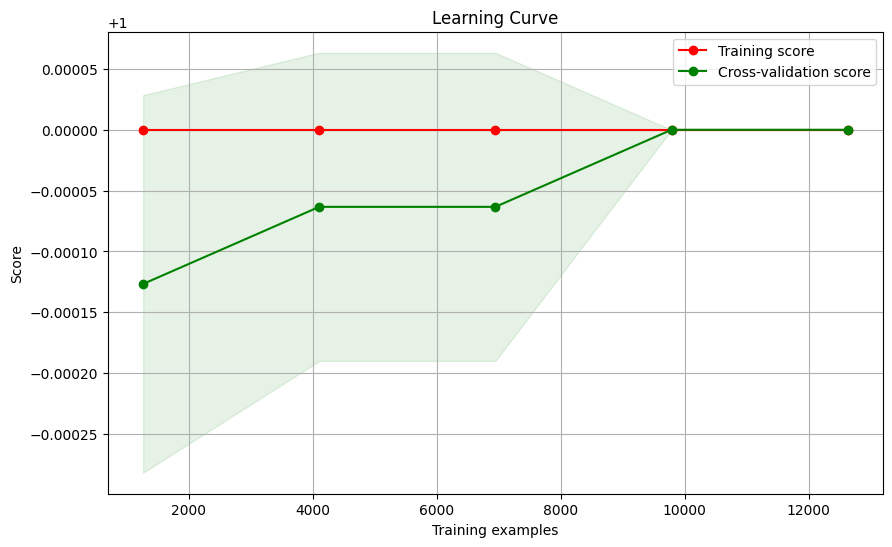

In [13]:
def plot_learning_curve(estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 5), cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, n_jobs=-1)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.title("Learning Curve")
    plt.grid()
    plt.show()


plot_learning_curve(best_gradient_boosting, X_train, y_train)




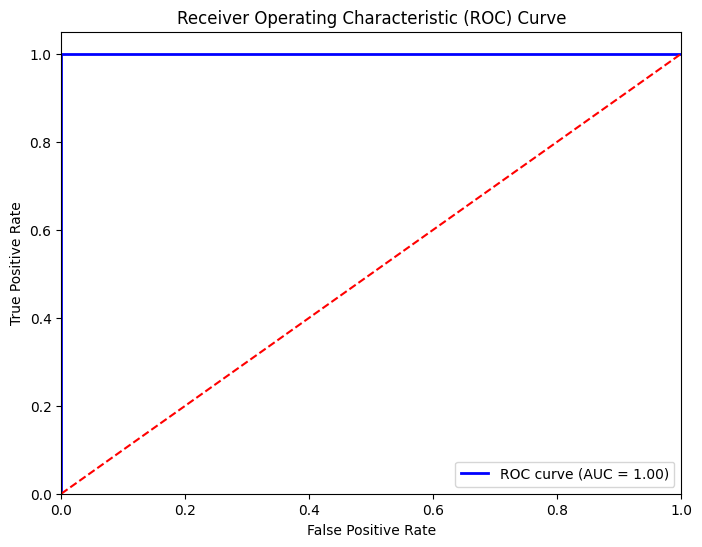

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predecir probabilidades de pertenencia a la clase positiva utilizando el modelo entrenado
y_probs = best_gradient_boosting.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calcular el área bajo la curva ROC
roc_auc = roc_auc_score(y_test, y_probs)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
